# ДЗ 6 Гладышев В.В.

Датасет дефолтов по кредитам

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import xgboost as xgb

from sklearn.model_selection import GridSearchCV

## Загрузка и подготовка данных

In [2]:
train = pd.read_csv("./data/pds_project_train.csv")
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [4]:
train['Id'] = np.arange(0, len(train))

In [5]:
def print_categorical(data):
    for cat_colname in data.columns:
        if len(data[cat_colname].unique()) < 20:
            print(str(cat_colname) + '\n\n' + str(data[cat_colname].unique()) + '\n\n')
            print(data.groupby(cat_colname)[cat_colname].count())
            print('*' * 100 + '\n')

In [6]:
print_categorical(train)

Home Ownership

['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']


Home Ownership
Have Mortgage      12
Home Mortgage    3637
Own Home          647
Rent             3204
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']


Years in current job
1 year        504
10+ years    2332
2 years       705
3 years       620
4 years       469
5 years       516
6 years       426
7 years       396
8 years       339
9 years       259
< 1 year      563
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

[0. 3. 1. 2. 4. 6. 5. 7.]


Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
**********

In [7]:
map_Jb = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
train["Years in current job"] = train["Years in current job"].map(map_Jb)

map_HO = {
    'Have Mortgage': 2,
    'Home Mortgage': 2,
    'Own Home': 3,
    'Rent': 1
}
train["Home Ownership"] = train["Home Ownership"].map(map_HO)

train["Years in current job"] = train["Years in current job"].fillna(0)

train.loc[train["Term"] == "Long Term", "Term"] = 1
train.loc[train["Term"] == "Short Term", "Term"] = 0

train["Term"] = train["Term"].astype(np.int64)

train.loc[(train['Bankruptcies'].isnull() & train['Months since last delinquent']), 'Bankruptcies'] = 1
train.loc[(train['Bankruptcies'].isnull() & (train['Months since last delinquent'] == 0)), 'Bankruptcies'] = 0

map_P = {
    'business loan': 1,
    'buy a car': 2,
    'buy house': 3,
    'debt consolidation': 4,
    'educational expenses': 5,
    'home improvements': 6,
    'major purchase': 7,
    'medical bills': 8,
    'moving': 9,
    'other': 10,
    'renewable energy': 11,
    'small business': 12,
    'take a trip': 13,
    'vacation': 14,
    'wedding': 15
}
train["Purpose"] = train["Purpose"].map(map_P)

In [8]:
tmp = train.loc[train['Months since last delinquent'] > 0].copy()

tmp_lst = tmp.groupby(['Number of Credit Problems'],as_index=False) \
            .agg({'Months since last delinquent':'mean'})['Months since last delinquent'].tolist()

for i in range(0, 8):
    train.loc[(((train['Months since last delinquent'].isnull()) | 
                (train['Months since last delinquent'] == 0)) & 
               (train['Number of Credit Problems'] == i)), ['Months since last delinquent']] = tmp_lst[i]

In [9]:
train.loc[train['Id'] == 6472, 'Annual Income'] = 1014934
train.loc[train['Id'] == 6472, 'Annual Income']

train.loc[train['Id'] == 44, 'Maximum Open Credit'] = 3800528
train.loc[train['Id'] == 44, 'Maximum Open Credit']

train.loc[train['Id'] == 617, 'Maximum Open Credit'] = 1304726
train.loc[train['Id'] == 617, 'Maximum Open Credit']

train.loc[train['Id'] == 2617, 'Maximum Open Credit'] = 2651287
train.loc[train['Id'] == 2617, 'Maximum Open Credit']

2617    2651287.0
Name: Maximum Open Credit, dtype: float64

### Выделение фрагментов с однозначным соответствием классу

In [10]:
train.loc[train['Credit Score'] > 850].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 69 to 7496
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                400 non-null    int64  
 1   Annual Income                 400 non-null    float64
 2   Years in current job          400 non-null    float64
 3   Tax Liens                     400 non-null    float64
 4   Number of Open Accounts       400 non-null    float64
 5   Years of Credit History       400 non-null    float64
 6   Maximum Open Credit           400 non-null    float64
 7   Number of Credit Problems     400 non-null    float64
 8   Months since last delinquent  400 non-null    float64
 9   Bankruptcies                  400 non-null    float64
 10  Purpose                       400 non-null    int64  
 11  Term                          400 non-null    int64  
 12  Current Loan Amount           400 non-null    float64
 13  Cur

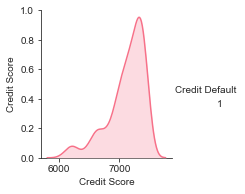

In [11]:
sns.set_style("ticks")
sns.pairplot(train.loc[train['Credit Score'] > 850, ['Credit Score', 'Credit Default']],
             hue = "Credit Default",
             diag_kind = "kde",
             kind = "scatter",
             palette = "husl")
plt.show()

In [12]:
train.loc[train['Current Loan Amount'] == 99999999].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 0 to 7497
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                870 non-null    int64  
 1   Annual Income                 870 non-null    float64
 2   Years in current job          870 non-null    float64
 3   Tax Liens                     870 non-null    float64
 4   Number of Open Accounts       870 non-null    float64
 5   Years of Credit History       870 non-null    float64
 6   Maximum Open Credit           870 non-null    float64
 7   Number of Credit Problems     870 non-null    float64
 8   Months since last delinquent  870 non-null    float64
 9   Bankruptcies                  870 non-null    float64
 10  Purpose                       870 non-null    int64  
 11  Term                          870 non-null    int64  
 12  Current Loan Amount           870 non-null    float64
 13  Curr

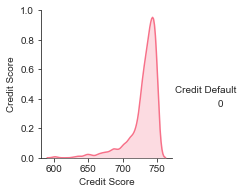

In [13]:
sns.set_style("ticks")
sns.pairplot(train.loc[train['Current Loan Amount'] == 99999999, ['Credit Score', 'Credit Default']],
             hue = "Credit Default",
             diag_kind = "kde",
             kind = "scatter",
             palette = "husl")
plt.show()

In [14]:
train['Credit Score'].mean()

1151.0874978966851

In [15]:
train.loc[train['Credit Score'].isnull(), 'Credit Score'] = 850

In [16]:
train.loc[train['Annual Income'].isnull(), 'Annual Income'] = train['Annual Income'].mean()

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

## Feature engineering

### Сочетания характеристик и математические преобразования

In [18]:
continuous_columns = ["Maximum Open Credit", "Annual Income", "Current Loan Amount", 
                      "Current Credit Balance", "Monthly Debt", "Credit Score"]

In [19]:
# генерируем признаки
def transform_data(data):
    for i1, col1 in enumerate(continuous_columns):
        data[col1 + '_log'] = np.log(data[col1] + 1.1)

        for i2, col2 in enumerate(continuous_columns):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2] + 0.1)
            data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

            data['%s_%s_11' % (col1, col2)] = data[col1] - np.log(data[col2] + 1)
            data['%s_%s_22' % (col1, col2)] = data[col1] + np.log(data[col2] + 1)
            data['%s_%s_33' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 0.1)
            data['%s_%s_44' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)

    return data


train = transform_data(train)

In [20]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in train.columns.to_list():
    train.loc[train[col].isnull(), col] = -1

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Columns: 312 entries, Home Ownership to Credit Score_Credit Score_44
dtypes: float64(307), int32(1), int64(4)
memory usage: 17.8 MB


## XGBoost

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(["Credit Default", "Id"], axis=1), 
                                                      train["Credit Default"], 
                                                      test_size=0.2, random_state=42)

In [23]:
model_xgb = xgb.XGBClassifier(objective="binary:logistic",
                              nthread=2, 
                              max_depth=9, # 5
                              n_estimators=600, # 100
                              subsample=0.5, 
                              learning_rate=0.3, 
                              seed=1000, 
                              random_state=42,
                              eval_metric='auc')

model_xgb.fit(X_train, y_train)

preds = model_xgb.predict(X_valid)

accuracy_score(y_valid, preds)

C:\Users\viv232\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\viv232\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.738

### XGBoost prediction

In [24]:
data_for_corr = X_valid.copy()
data_for_corr["preds"] = preds
data_for_corr.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score_Monthly Debt_44,Credit Score_Credit Score_1,Credit Score_Credit Score_2,Credit Score_Credit Score_3,Credit Score_Credit Score_4,Credit Score_Credit Score_11,Credit Score_Credit Score_22,Credit Score_Credit Score_33,Credit Score_Credit Score_44,preds
970,2,2.396375e+06,6.0,0.0,9.0,10.5,335280.0,1.0,8.000000,1.0,...,74257.830846,0.0,14260.0,0.999986,50836900.0,7121.127793,7138.872207,794.676292,63258.834170,1
6279,2,1.364855e+06,5.0,0.0,8.0,14.0,883014.0,0.0,33.521424,0.0,...,6934.738808,0.0,1700.0,0.999882,722500.0,843.253588,856.746412,124.152620,5734.450309,0
1859,2,2.056351e+06,10.0,0.0,17.0,14.0,1022714.0,0.0,33.521424,0.0,...,7380.772065,0.0,1436.0,0.999861,515524.0,711.422139,724.577861,107.519453,4722.904455,0


In [25]:
data_for_corr.loc[data_for_corr['Credit Score'] > 850, "preds"].sum()

86

In [26]:
data_for_corr.loc[data_for_corr['Current Loan Amount'] == 99999999, "preds"].sum()

0

In [27]:
rw_clissifiers = ['XGBoost']

cl_met = ['Best Threshold', 'F-Score', 'Precision', 
          'Recall', 'roc_auc_s', 'log_loss_s', 'TPR', 'FPR', 'TNR', "TN", "FN", "TP", "FP"]

res_tab = pd.DataFrame(columns=cl_met)

In [28]:
precision, recall, thresholds = precision_recall_curve(y_valid, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=1.000000, F-Score=0.465, Precision=0.582, Recall=0.388


In [29]:
r_auc = roc_auc_score(y_true=y_valid, y_score=preds)
l_los = log_loss(y_true=y_valid, y_pred=preds)

print("roc auc score: {}".format(r_auc))
print("log loss score: {}".format(l_los))

roc auc score: 0.6358038966294733
log loss score: 9.049224982455875


In [30]:
cnf_matrix = confusion_matrix(y_valid, preds)

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.3877551020408163, 0.11614730878186968, 0.8838526912181303)

In [31]:
res_tab.loc['XGBoost', :] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                             r_auc, l_los, TPR, FPR, TNR, TN, FN, TP, FP]
res_tab

,Best Threshold,F-Score,Precision,Recall,roc_auc_s,log_loss_s,TPR,FPR,TNR,TN,FN,TP,FP
XGBoost,1,0.465306,0.581633,0.387755,0.635804,9.04922,0.387755,0.116147,0.883853,936,270,171,123
